In [41]:
import random
import numpy as np
from model import Model_3DCNN, strip_prefix_if_present
from data_reader import Dataset_MLHDF
from img_util import GaussianFilter, Voxelizer3D
from file_util import *
import torch
import torch.nn as nn

from torch.nn.parallel import DataParallel, DistributedDataParallel
from torch.optim import Adam, RMSprop, lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset

In [46]:
# import required libraries
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt

# Read H5 file
f = h5.File('../../data/processed/pdbbind2016_general_train.hdf', "r")
# Get and print list of datasets within the H5 file
datasetNames = [n for n in f.keys()]
data = f.values()

In [47]:
len(datasetNames)

8322

In [48]:
mlhdf_ds = f['1maw']['pybel']['processed']['pdbbind']
actual_data = mlhdf_ds["data"][:]

In [49]:
actual_data.shape

(382, 22)

In [50]:
dataset = Dataset_MLHDF('../../data/processed/pdbbind2016_general_train.hdf', 1, '../../data/processed/general_train_3dnn.csv', is_crystal=True, rmsd_weight=0, rmsd_thres=2)


In [51]:
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, num_workers=0, worker_init_fn=None)

In [52]:
voxelizer = Voxelizer3D(use_cuda=False, verbose=1)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

In [91]:
device = torch.device("cpu")
vol_batch = torch.zeros((50,19,48,48,48)).float().to(device)
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)

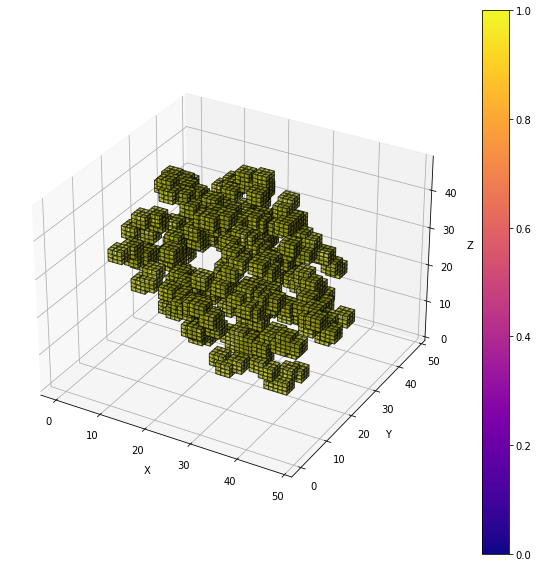

In [69]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
colors = plt.cm.plasma(d)
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
ax.voxels(d,facecolors=colors,alpha = 0.5,edgecolor='k')

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [58]:
d2 = vol_batch_gaus[0][1].numpy()
d2[abs(d2)>1e-6]

array([2.38037001e-06, 5.51893845e-06, 7.42517113e-06, ...,
       2.82466899e-05, 1.22104975e-05, 2.38022994e-06], dtype=float32)

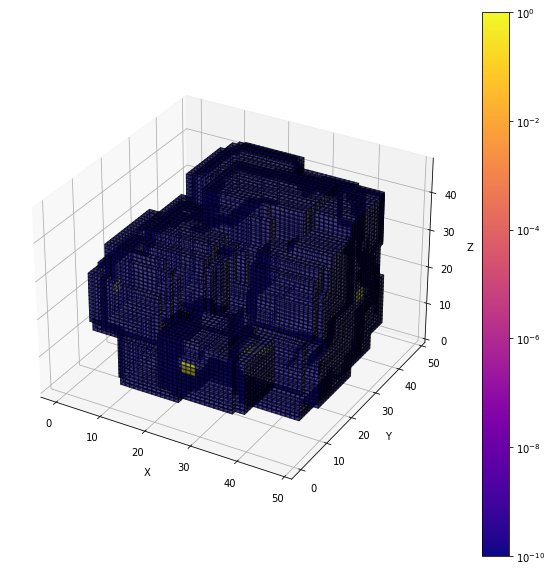

In [63]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
colors = plt.cm.plasma(d)
norm = matplotlib.colors.LogNorm(vmin=1e-10, vmax=1)
ax.voxels(d2,facecolors=colors,alpha = 0.5,edgecolor='k')

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [116]:
d.shape

(48, 48, 48)

In [148]:
d = vol_batch_gaus[10][1].numpy()
d[:2,:2,:2]=26
d[2:4,2:4,2:4]=29
# Rolling 3D window for ND array
def roll(a,      # ND array
         b,      # rolling 2D window array
         dx=1,   # horizontal step, abscissa, number of columns
         dy=1,   # vertical step, ordinate, number of rows
         dz=1):  # transverse step, applicate, number of layers
    shape = a.shape[:-3] + \
            ((a.shape[-3] - b.shape[-3]) // dz + 1,) + \
            ((a.shape[-2] - b.shape[-2]) // dy + 1,) + \
            ((a.shape[-1] - b.shape[-1]) // dx + 1,) + \
            b.shape  # multidimensional "sausage" with 3D cross-section
    strides = a.strides[:-3] + \
              (a.strides[-3] * dz,) + \
              (a.strides[-2] * dy,) + \
              (a.strides[-1] * dx,) + \
              a.strides[-3:]
    print('shape =', shape, " strides =", strides)  # for debugging
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

b=np.zeros((2,2,2))
windows = roll(d,b,dx=2,dy=2,dz=2).reshape(-1,2,2,2)
windows.shape

shape = (24, 24, 24, 2, 2, 2)  strides = (18432, 384, 8, 9216, 192, 4)


(13824, 2, 2, 2)

In [1]:
from file_util import *
from img_util import GaussianFilter, Voxelizer3D
from data_reader import Dataset_MLHDF
from model import Model_3DCNN, strip_prefix_if_present
from scipy.stats import *
from sklearn.metrics import *
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.parallel import DataParallel, DistributedDataParallel
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import math
import random
import argparse
import os
import sys

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {}
args['device-name'] = "cuda:0"
args['data-dir'] = "../../data/processed"
args['dataset-type'] = 1
args['csv-fn'] = "core_test_3dnn.csv"
args['mlhdf-fn'] = "pdbbind2016_core_test.hdf"
args['model-path'] = "../../data/pdbbind2016_refined_model.pth"
args['complex-type'] = 1
args['rmsd-threshold'] = 100
args['batch-size'] = 50
args['multi-gpus'] = False
args['save-pred'] = True
args['save-feat'] = True

In [4]:
# set CUDA for PyTorch
use_cuda = torch.cuda.is_available()
cuda_count = torch.cuda.device_count()
if use_cuda:
    device = torch.device(args['device_name'])
    torch.cuda.set_device(int(args['device_name'].split(':')[1]))
else:
    device = torch.device("cpu")
print(use_cuda, cuda_count, device)


# load dataset
if args['complex-type'] == 1:
    is_crystal = True
else:
    is_crystal = False
dataset = Dataset_MLHDF(os.path.join(args['data-dir'], args['mlhdf-fn']), args['dataset-type'], os.path.join(
    args['data-dir'], args['csv-fn']), is_crystal=is_crystal, rmsd_weight=False, rmsd_thres=args['rmsd-threshold'])

# check multi-gpus
num_workers = 0
if args['multi-gpus'] and cuda_count > 1:
    num_workers = cuda_count

# initialize data loader
batch_size = args['batch-size']
batch_count = len(dataset) // batch_size
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, num_workers=num_workers, worker_init_fn=None)

# define voxelizer, gaussian_filter
voxelizer = Voxelizer3D(use_cuda=use_cuda, verbose=0)
gaussian_filter = GaussianFilter(
    dim=3, channels=19, kernel_size=5, sigma=1, use_cuda=use_cuda)

# define model
model = Model_3DCNN(use_cuda=use_cuda, verbose=0)
# if use_cuda:
#model = model.cuda()
if args['multi-gpus'] and cuda_count > 1:
    model = nn.DataParallel(model)
model.to(device)

if isinstance(model, (DistributedDataParallel, DataParallel)):
    model_to_save = model.module
else:
    model_to_save = model

# load model
if not valid_file(args['model-path']):
    print("checkpoint not found! %s" % args['model-path'])

checkpoint = torch.load(args['model-path'], map_location=device)
#checkpoint = torch.load(args.model_path)
model_state_dict = checkpoint.pop("model_state_dict")
strip_prefix_if_present(model_state_dict, "module.")
model_to_save.load_state_dict(model_state_dict, strict=False)
output_dir = os.path.dirname(args['model-path'])

vol_batch = torch.zeros((batch_size, 19, 48, 48, 48)).float().to(device)
ytrue_arr = np.zeros((len(dataset),), dtype=np.float32)
ypred_arr = np.zeros((len(dataset),), dtype=np.float32)
zfeat_arr = np.zeros((len(dataset), 100), dtype=np.float32)
pred_list = []

model.eval()

False 0 cpu


/home/vscode/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model_3DCNN(
  (conv_block1): Sequential(
    (0): Conv3d(19, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
    (1): ReLU(inplace=True)
    (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_block1): Sequential(
    (0): Conv3d(64, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
    (1): ReLU(inplace=True)
    (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_block2): Sequential(
    (0): Conv3d(64, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
    (1): ReLU(inplace=True)
    (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(7, 7, 7), stride=(3, 3, 3), padding=(3, 3, 3))
    (1): ReLU(inplace=True)
    (2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (max_pool2): MaxPool3d(kernel_size=2, stride=2, p

In [5]:
dataset = Dataset_MLHDF('../../data/processed/pdbbind2016_refined_train.hdf', 1, '../../data/processed/refined_train_3dnn.csv', is_crystal=True, rmsd_weight=0, rmsd_thres=100)
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, num_workers=num_workers, worker_init_fn=None)

In [12]:
pdbid, poseid, affinity = dataset.data_info_list[0]
affinity

6.4

In [13]:
pdbid

'10gs'

In [15]:
j=0
for bind, batch in enumerate(dataloader):
    print(j)
    j+=1
    # transfer to GPU
    x_batch_cpu, y_batch_cpu = batch
    x_batch, y_batch = x_batch_cpu.to(device), y_batch_cpu.to(device)
    # voxelize into 3d volume
    bsize = x_batch.shape[0]
    for i in range(bsize):
        xyz, feat = x_batch[i, :, :3], x_batch[i, :, 3:]
        vol_batch[i, :, :, :, :] = voxelizer(xyz, feat)
    vol_batch = gaussian_filter(vol_batch)
    break;

0


In [17]:
vol_batch.shape

torch.Size([50, 19, 48, 48, 48])

In [136]:
import csv
with open('../../data/processed/core_test_3dnn.csv', 'r') as fp:
    csv_reader = csv.reader(fp, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        #print([row[0], row[1], float(row[2]), float(row[3])])
        if float(row[2]) <= 100:
            print([row[0], row[1], float(row[2]), float(row[3])])

['1a30', '2/core_test_3dnn/1a30', 4.3, 2.0]
['1bcu', '2/core_test_3dnn/1bcu', 3.28, 2.0]
['1bzc', '2/core_test_3dnn/1bzc', 4.92, 2.0]
['1c5z', '2/core_test_3dnn/1c5z', 4.01, 2.0]
['1e66', '2/core_test_3dnn/1e66', 9.89, 2.0]
['1eby', '2/core_test_3dnn/1eby', 9.7, 2.0]
['1g2k', '2/core_test_3dnn/1g2k', 7.96, 2.0]
['1gpk', '2/core_test_3dnn/1gpk', 5.37, 2.0]
['1gpn', '2/core_test_3dnn/1gpn', 6.48, 2.0]
['1h22', '2/core_test_3dnn/1h22', 9.1, 2.0]
['1h23', '2/core_test_3dnn/1h23', 8.35, 2.0]
['1k1i', '2/core_test_3dnn/1k1i', 6.58, 2.0]
['1lpg', '2/core_test_3dnn/1lpg', 7.09, 2.0]
['1mq6', '2/core_test_3dnn/1mq6', 11.15, 2.0]
['1nc1', '2/core_test_3dnn/1nc1', 6.12, 2.0]
['1nc3', '2/core_test_3dnn/1nc3', 5.0, 2.0]
['1nvq', '2/core_test_3dnn/1nvq', 8.25, 2.0]
['1o0h', '2/core_test_3dnn/1o0h', 5.92, 2.0]
['1o3f', '2/core_test_3dnn/1o3f', 7.96, 2.0]
['1o5b', '2/core_test_3dnn/1o5b', 5.77, 2.0]
['1owh', '2/core_test_3dnn/1owh', 7.4, 2.0]
['1oyt', '2/core_test_3dnn/1oyt', 7.24, 2.0]
['1p1n', '2/co